In [1]:
import pandas as pd

**Data used**


[https://www.kaggle.com/datasets/ajax0564/quotes-dataset](http://)

In [2]:
df = pd.read_csv("../input/transformer-dataprep/All_Quotes.csv")

In [3]:
df.shape

(526110, 3)

In [4]:
df.head(3)

,quote,index,text_length
0,If you do not take an interest in the affairs ...,NaN,NaN
1,A wise man speaks because he has something to ...,NaN,NaN
2,"Someday, in the distant future, our grand-chil...",NaN,NaN


In [5]:
df["quote_length"] = df["quote"].apply(lambda x: len(x.split()))

# Get the maximum and minimum text lengths
max_text_length = df["quote_length"].max()
min_text_length = df["quote_length"].min()

# Print the results
print("Maximum text length:", max_text_length)
print("Minimum text length:", min_text_length)

Maximum text length: 5459

Minimum text length: 1


In [6]:
dff = df[df["quote_length"] >= 5].reset_index(drop=True)

In [7]:
dff[dff["quote_length"] == 5]

,quote,index,text_length,quote_length
46900,Self-talk reflects your innermost feelings.,1789.0,43.0,5
47247,"Sometimes, remembering hurts too much.",2145.0,38.0,5
47530,Because...because...she came here with me.,2438.0,42.0,5
48532,Cynics are simply thwarted romantics.,3471.0,37.0,5
49073,"Forget injuries, never forget kindnesses.",4032.0,41.0,5
...,...,...,...,...
517685,Every relationship has its complications.,491243.0,41.0,5
518209,Success demands singleness of purpose.,491783.0,38.0,5
519378,Men aren't necessities. They're luxuries.,492984.0,41.0,5
519663,Getting angry doesn't solve anything.,493277.0,37.0,5


**Reading Material to understand MLM**


https://web.stanford.edu/~jurafsky/slp3/11.pdf](http://)

In [8]:
import os
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
import gc
import numpy as np
from transformers import AutoConfig
from tqdm.notebook import tqdm

os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings

warnings.simplefilter("ignore")

In [9]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [10]:
import torch


class MLMDataset(Dataset):
    def __init__(self, text):
        self.text = text
        self.max_len = 128
        self.tokenizer = tokenizer
        self.num_examples = len(self.text)

    def __len__(self):
        return self.num_examples

    def __getitem__(self, idx):
        text = str(self.text[idx])

        tokenized_text = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_attention_mask=True,
        )

        ids = tokenized_text["input_ids"]
        mask = tokenized_text["attention_mask"]

        return {
            "input_ids": torch.tensor(ids, dtype=torch.long),
            "attention_mask": torch.tensor(mask, dtype=torch.long),
        }

In [11]:
import torch
from typing import Optional, Tuple


def masked_language_modeling(
    input_ids: torch.Tensor,
    tokenizer=tokenizer,
    fraction: float = 0.15,
    ignore_index: int = -100,
) -> Tuple[torch.Tensor]:
    label = input_ids.clone()

    special_tokens_mask = torch.tensor(
        [
            tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True)
            for val in label.tolist()
        ],
        dtype=torch.bool,
    )  # get all special token mask to ignore their selection in MLM
    probability_matrix = torch.full(
        label.shape, fraction
    )  # gen probability matrix to select 15% tokens for MLM
    probability_matrix.masked_fill_(
        special_tokens_mask, value=0.0
    )  # zero out the probability of special tokens so that they do not get selected
    # https://pytorch.org/docs/stable/generated/torch.bernoulli.html
    # Draws binary random numbers (0 or 1) from a Bernoulli distribution.
    masked_indices = torch.bernoulli(probability_matrix).bool()

    label[~masked_indices] = (
        ignore_index  # We only compute loss on masked tokens cross entropy ignore_index
    )

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = (
        torch.bernoulli(torch.full(label.shape, 0.8)).bool() & masked_indices
    )  # rondomly select 80% tokens from 15% token
    input_ids[indices_replaced] = tokenizer.convert_tokens_to_ids(
        tokenizer.mask_token
    )  # replace it with [MASK]

    # 10% of the time, we replace masked input tokens with random word
    indices_random = (
        torch.bernoulli(torch.full(label.shape, 0.5)).bool()
        & masked_indices
        & ~indices_replaced
    )  # from 15% ignore 80% select 10% from 20%
    random_words = torch.randint(
        len(tokenizer), label.shape, dtype=torch.long
    )  # get random token index from tokenizer
    input_ids[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged do nothing
    #     batch['input_ids_modified'] = input_ids
    #     batch['label'] = label
    #     batch['masked_indices'] = masked_indices
    return input_ids, label, masked_indices

In [12]:
!pip install einops




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00




In [13]:
import torch
import torch.nn as nn
from einops import rearrange, reduce
from typing import Optional, Tuple


class AbsoluteEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.pos_embeddings = nn.Embedding(
            config.max_position_embeddings, config.hidden_size
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )
        self.max_size = config.max_position_embeddings

    def forward(self, size: int) -> torch.Tensor:
        if self.max_size < size:
            raise ValueError(
                f"The hidden size ({size }) is more than the config max_position_embeddings {self.max_size}"
            )
        return self.pos_embeddings(self.position_ids[:, :size])


class SinusoidalEncoding(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        if config.hidden_size % 2 != 0:
            raise ValueError(
                f"Cannot use SinusoidalEncoding with "
                "odd hidden dim got dim {config.hidden_size}"
            )
        self.positional_encoding = torch.zeros(
            1, config.max_position_embeddings, config.hidden_size
        )
        self.position = torch.arange(0, config.max_position_embeddings).unsqueeze(1)
        self.div_term = torch.exp(
            (
                torch.arange(0, config.hidden_size, 2, dtype=torch.float)
                * -(torch.log(torch.tensor(10000.0)) / config.hidden_size)
            )
        )

        self.positional_encoding[:, :, 0::2] = torch.sin(
            self.position.float() * self.div_term
        )
        self.positional_encoding[:, :, 1::2] = torch.cos(
            self.position.float() * self.div_term
        )

    def forward(self, seq_len: int) -> torch.Tensor:

        return self.positional_encoding[:, :seq_len]


# copied from transformer/models/gemma
class RotaryEmbedding(nn.Module):
    def __init__(self, config, base=10000, device=None):
        super().__init__()

        self.dim = int(config.hidden_size // config.num_attention_heads)
        self.max_position_embeddings = config.max_position_embeddings
        self.base = base
        self.register_buffer(
            "inv_freq",
            1.0
            / (
                self.base
                ** (torch.arange(0, self.dim, 2, dtype=torch.int64).float() / self.dim)
            ),
            persistent=False,
        )
        self.register_buffer(
            "position_ids",
            torch.arange(config.max_position_embeddings).expand((1, -1)),
            persistent=False,
        )

    @torch.no_grad()
    def forward(self, seq_len: int = None):
        # x: [bs, num_attention_heads, seq_len, head_size]
        # size = x.size()[2]
        position_ids = torch.arange(seq_len).unsqueeze(0)
        # position_ids = self.position_ids[:, :size].float()

        inv_freq_expanded = (
            self.inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
        )
        position_ids_expanded = position_ids[:, None, :].float()

        freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(
            1, 2
        )
        return freqs


# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


# def rotate_half(x):
#     x1, x2 = x.chunk(2, dim=-1)
#     return torch.cat((-x2, x1), dim=-1)


# Copied from transformers.models.llama.modeling_llama.apply_rotary_pos_emb
def apply_rotary_pos_emb(
    q, k, freqs, only_q: bool = False, unsqueeze_dim=1
) -> Tuple[torch.Tensor]:
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        freqs: precalculated frqs for sin cos
        only_q: bool = False for encoder decoder
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    emb = torch.cat((freqs, freqs), dim=-1)
    cos = emb.cos()
    sin = emb.sin()
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    #     print(cos.size(),sin.size(),q.size(),k.size())
    if only_q:
        q_embed = (q * cos) + (rotate_half(q) * sin)
    else:

        q_embed = (q * cos) + (rotate_half(q) * sin)
        k_embed = (k * cos) + (rotate_half(k) * sin)
        return q_embed, k_embed

In [14]:
import torch
import torch.nn as nn
from einops import rearrange, reduce
from typing import Optional, Tuple, Union

_ACT_ = {
    "gelu": nn.GELU(),
    "leaky_relu": nn.LeakyReLU(),
    "relu6": nn.ReLU6(),
    "sigmoid": nn.Sigmoid(),
    "silu": nn.SiLU(),
    "swish": nn.SiLU(),
    "tanh": nn.Tanh(),
}


class FeedForward(nn.Module):
    def __init__(self, config, multiplier: Union[int, float] = 4) -> None:
        super().__init__()
        self.intermediate = nn.Linear(
            config.hidden_size, int(multiplier) * config.hidden_size
        )
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.layerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        if _ACT_.get(getattr(config, "hidden_act", None), None):
            self.act_fn = _ACT_[config.hidden_act]
        else:
            self.act_fn = nn.GELU()
        self.out = nn.Linear(int(multiplier) * config.hidden_size, config.hidden_size)

    def forward(
        self, hidden_state: torch.Tensor, input_tensor: torch.Tensor
    ) -> torch.Tensor:
        output = self.intermediate(hidden_state)
        output = self.act_fn(output)
        output = self.out(output)
        output = self.dropout(output)
        output = self.layerNorm(output + input_tensor)
        return output

In [15]:
def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(
        batch, num_key_value_heads, n_rep, slen, head_dim
    )
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


def repeat_kv_einops(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = repeat(
        hidden_states,
        "batch num_key_value_heads slen head_dim -> batch num_key_value_heads n_rep slen head_dim",
        n_rep=n_rep,
    )  # hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    # return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)
    return rearrange(
        hidden_states,
        "batch num_key_value_heads n_rep slen head_dim -> batch (num_key_value_heads n_rep) slen head_dim",
    )


class EncoderAttention(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.head_size = int(config.hidden_size // config.num_attention_heads)
        self.attention_bias = getattr(config, "attention_bias", True)
        self.layer_idx = layer_idx
        # self.qkv = nn.Linear(config.hidden_size,3*config.hidden_size)
        self.q = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.k = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.v = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.out = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.num_attention_heads = config.num_attention_heads

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        q = self.q(hidden_state)
        k = self.k(hidden_state)
        v = self.v(hidden_state)
        # q,k,v = self.qkv(hidden_state).chunk(3, dim = -1) #b X l X d dim =-1 or 2
        # place holder for RoPe operation
        q = rearrange(q, "b l (h d) -> b h l d", h=self.num_attention_heads)
        k = rearrange(k, "b l (h d) -> b h l d", h=self.num_attention_heads)
        v = rearrange(v, "b l (h d) -> b h l d", h=self.num_attention_heads)
        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask, is_causal=False
        )
        out = rearrange(out, "b h l d -> b l (h d)")
        out = self.out(out)
        return out


class EncoderAttentionGqa(nn.Module):
    def __init__(self, config, layer_idx: int) -> None:
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )
        self.flash = hasattr(torch.nn.functional, "scaled_dot_product_attention")
        if not self.flash and self.layer_idx == 0:  # avoid to print m times
            print("WARNING: Flash Attention requires PyTorch >= 2.0")
        self.layer_idx = layer_idx
        self.head_dim = int(config.hidden_size // config.num_attention_heads)
        self.num_attention_heads = config.num_attention_heads
        self.num_key_value_heads = getattr(config, "num_key_value_heads", 4)
        self.num_key_value_groups = self.num_attention_heads // self.num_key_value_heads
        if (
            self.num_attention_heads % self.num_key_value_heads != 0
            or self.num_attention_heads < self.num_key_value_heads
        ):
            raise ValueError(
                f"num_key_value_heads {self.num_key_value_heads }  should be less than equal num_attention_heads {config.num_attention_heads} and  multiple of num_attention_heads {config.num_attention_heads} "
            )
        self.attention_bias = getattr(config, "attention_bias", True)
        self.out = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.q = nn.Linear(
            config.hidden_size, config.hidden_size, bias=self.attention_bias
        )
        self.k = nn.Linear(
            config.hidden_size,
            self.num_key_value_heads * self.head_dim,
            bias=self.attention_bias,
        )
        self.v = nn.Linear(
            config.hidden_size,
            self.num_key_value_heads * self.head_dim,
            bias=self.attention_bias,
        )

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        q = self.q(hidden_state)
        k = self.k(hidden_state)
        v = self.v(hidden_state)
        q = rearrange(q, "b l (h d) -> b h l d", d=self.head_dim)
        k = rearrange(k, "b l (h d) -> b h l d", d=self.head_dim)
        v = rearrange(v, "b l (h d) -> b h l d", d=self.head_dim)

        if freqs is not None:
            q, k = apply_rotary_pos_emb(q, k, freqs)

        k = repeat_kv(k, n_rep=self.num_key_value_groups)
        v = repeat_kv(v, n_rep=self.num_key_value_groups)
        out = torch.nn.functional.scaled_dot_product_attention(
            query=q, key=k, value=v, attn_mask=attention_mask, is_causal=False
        )
        out = rearrange(out, "b h l d -> b l (h d)")
        out = self.out(out)
        return out

In [16]:
import torch
import torch.nn as nn
from typing import Optional, Tuple
from dataclasses import dataclass

_position_embeddings = {
    "absolute": AbsoluteEncoding,
    "sinusoidal": SinusoidalEncoding,
}  #'relative':RelativePositionalEncoding


@dataclass
class EncoderOutput(object):
    logits: torch.Tensor


@dataclass
class MLMOutput(object):
    hidden_state: torch.Tensor
    logits: torch.Tensor


class EncoderLayer(nn.Module):
    def __init__(self, config, layer_idx: int, attention_type: str = None) -> None:
        super().__init__()
        self.attention = (
            EncoderAttentionGqa(config, layer_idx=layer_idx)
            if attention_type == "gqa"
            else EncoderAttention(config, layer_idx=layer_idx)
        )
        if attention_type == "gqa" and layer_idx == 0:  # avoid to print m times
            print("Encoder Using GQA Attention")
        self.feed_forward = FeedForward(config)
        self.layer_idx = layer_idx

    def forward(
        self,
        hidden_state: torch.Tensor,
        attention_mask: torch.Tensor,
        freqs: torch.Tensor = None,
    ) -> torch.Tensor:
        out = self.attention(
            hidden_state=hidden_state, attention_mask=attention_mask, freqs=freqs
        )
        out = self.feed_forward(out, hidden_state)
        return out


class LMHead(nn.Module):
    """Head for masked language modelling"""

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

        self.decoder = nn.Linear(config.hidden_size, config.vocab_size)
        self.bias = nn.Parameter(torch.zeros(config.vocab_size))
        self.decoder.bias = self.bias

    def forward(self, hidden_state: torch.Tensor) -> torch.Tensor:
        x = self.dense(hidden_state)
        x = nn.GELU()(x)
        x = self.layer_norm(x)

        # project back to size of vocabulary with bias
        x = self.decoder(x)

        return x


class EncoderModel(nn.Module):

    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.word_embeddings = nn.Embedding(
            config.vocab_size,
            config.hidden_size,
            padding_idx=getattr(config, "pad_token_id", None),
        )
        if _position_embeddings.get(pos_embedding_type, None) is not None:
            self.position_embeddings = _position_embeddings.get(pos_embedding_type)(
                config
            )
        else:
            self.position_embeddings = None
        if pos_embedding_type == "rope":
            self.emb_freq = RotaryEmbedding(config)(config.max_position_embeddings)
            print(
                "Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable"
            )
        self.all_layer = nn.ModuleList(
            [
                EncoderLayer(config, layer_idx, attention_type)
                for layer_idx in range(config.num_hidden_layers)
            ]
        )

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        bsz, seqlen = input_ids.shape
        hidden_state = self.word_embeddings(input_ids)
        freqs = None
        if self.position_embeddings is not None:
            pos_info = self.position_embeddings(seqlen)[:, :seqlen, :].to(
                input_ids.device
            )
            hidden_state = hidden_state + pos_info
        else:
            freqs = self.emb_freq[:, :seqlen].to(input_ids.device)

        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2).type_as(hidden_state)
        attention_mask = (1.0 - attention_mask) * torch.finfo(hidden_state.dtype).min

        for layer in self.all_layer:
            hidden_state = layer(hidden_state, attention_mask, freqs)
        return EncoderOutput(hidden_state)

    @classmethod
    def from_config(
        cls,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> nn.Module:
        return cls(config, pos_embedding_type, attention_type)


class EncoderForMaskedLM(nn.Module):

    def __init__(
        self,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> None:
        super().__init__()
        self.encoder = EncoderModel(
            config, pos_embedding_type=pos_embedding_type, attention_type=attention_type
        )
        self.lm_head = LMHead(config=config)

    def forward(
        self, input_ids: torch.Tensor, attention_mask: torch.Tensor
    ) -> torch.Tensor:
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.lm_head(out.logits)
        return MLMOutput(hidden_state=out.logits, logits=logits)

    @classmethod
    def from_config(
        cls,
        config,
        pos_embedding_type: Optional[str] = "absolute",
        attention_type: str = None,
    ) -> nn.Module:
        return cls(config, pos_embedding_type, attention_type)

In [17]:
config = AutoConfig.from_pretrained(model_ckpt)

In [18]:
config.num_hidden_layers = 6
model = EncoderForMaskedLM(config, pos_embedding_type="rope")

Encoder Ignoring sinusoidal or absolute position embeddings because rope,is enable


In [19]:
m = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# print(model.encoder.word_embeddings.weight.size(),model.encoder.position_embeddings.pos_embeddings.weight.size())

**Copy Embeddings for faster convergence**

In [21]:
model.encoder.word_embeddings.weight = m.embeddings.word_embeddings.weight
# model.encoder.position_embeddings.pos_embeddings.weight =  m.embeddings.position_embeddings.weight

In [22]:
dff = dff.sample(frac=0.02, random_state=42)
dff.shape

(10520, 4)

In [23]:
train_dataset = MLMDataset(text=dff["quote"].values)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)

In [24]:
from accelerate import Accelerator
import sys


def single_gpu():
    accumulation_steps = 1  # batch size 128 large dont need gradient accumulation
    lr = 1e-3
    EPOCHS = 10
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator = Accelerator(
        log_with="tensorboard",
        project_dir=".",
    )
    accelerator.init_trackers("MLM_project", config=Config)

    model.cuda()

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr)
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )  # PyTorch scheduler

    scaler = torch.cuda.amp.GradScaler()
    epoch_check = len(train_loader)
    total_step = epoch_check * EPOCHS
    train_bar = tqdm(total=total_step, dynamic_ncols=True)
    t_step = 1
    k = 0
    model.train()
    for epoch in range(EPOCHS):
        avg_loss = 0.0
        loss_list = []
        running_loss = 0.0
        for step, data in enumerate(train_loader):
            train_bar.update(1)
            #         train_bar.set_description(f"step: {i+1} epoch: {epoch+1}")
            input_ids, label, _ = masked_language_modeling(input_ids=data["input_ids"])
            input_ids = input_ids.cuda()
            input_masks = data["attention_mask"].cuda()
            label = label.long().cuda()
            with torch.cuda.amp.autocast():
                pred = model(input_ids, input_masks)
            loss = loss_fn(pred.logits.transpose(1, 2), label)
            scaler.scale(loss).backward()
            if step % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            accelerator.log({"training_loss_step": loss}, step=t_step)

            train_bar.set_description(
                f'epoch: {epoch+1} step: {t_step} loss: {"%.4f" % loss}'
            )
            t_step += 1
            #             running_loss += loss.detach().cpu().item()
            #             if t_step % 100 == 99:
            #                 last_loss = running_loss / 100 # loss per batch
            #                 print('  batch {} loss: {}'.format(t_step, last_loss))
            #                 accelerator.log({"training_loss_100_step": last_loss}, step= k)
            #                 running_loss = 0.0
            #                 k+=1
            #                 running_loss = 0.0
            loss_list.append(loss.detach().cpu().item())
        scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"training_loss_epoch": avg_loss}, step=epoch + 1)
        print(f'Epoch: {epoch+1} loss: {"%.4f" % avg_loss }')
    accelerator.end_training()
    PATH = f"encoder_mlm_{epoch}.pth"
    torch.save(model.state_dict(), PATH)

In [25]:
 single_gpu()

2024-04-29 07:43:20.898138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

2024-04-29 07:43:20.898246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered

2024-04-29 07:43:21.027355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


  0%|          | 0/830 [00:00<?, ?it/s]

Epoch: 1 loss: 10.9549

Epoch: 2 loss: 9.3715

Epoch: 3 loss: 7.5514

Epoch: 4 loss: 6.9679

Epoch: 5 loss: 6.4087

Epoch: 6 loss: 5.7537

Epoch: 7 loss: 5.3792

Epoch: 8 loss: 5.1183

Epoch: 9 loss: 4.9247

Epoch: 10 loss: 4.7339


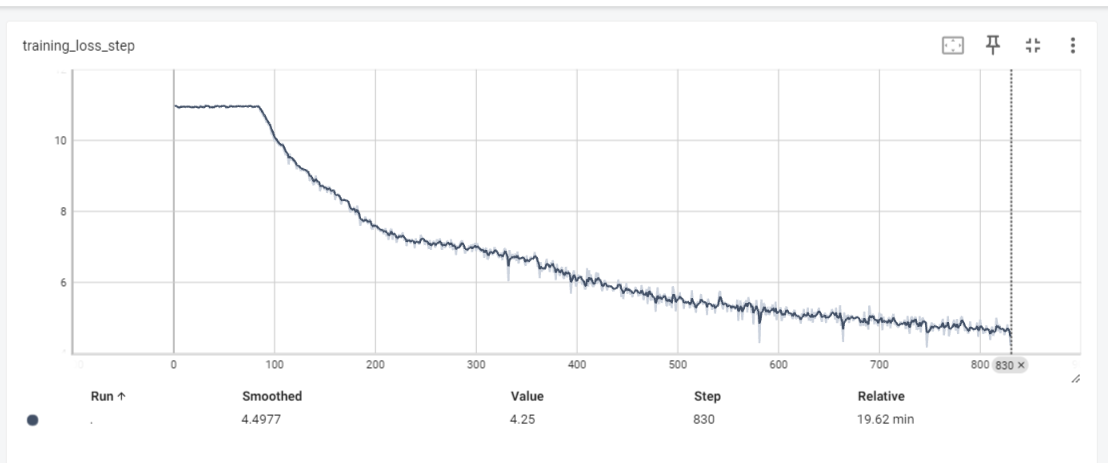

In [9]:
from PIL import Image
Image.open("../input/vyom-ai-images/MLM.png").convert("RGB")


![LossCurve](<attachment:Screenshot 2024-04-29 133812.png>)
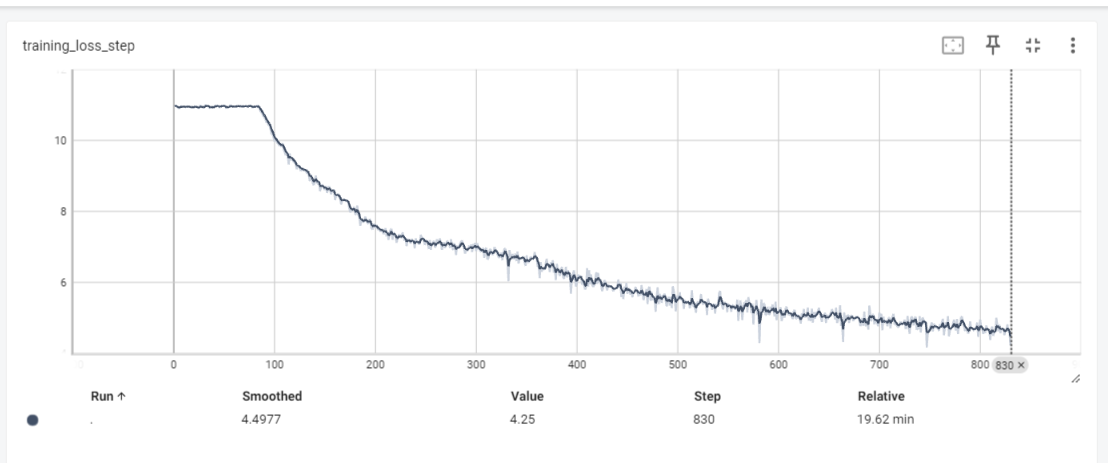

In [33]:
check = "stress shows on <mask> face."
inputs = tokenizer(check, truncation=True, padding=True, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
input_ids = inputs["input_ids"].cuda()
attention_mask = inputs["attention_mask"].cuda()
with torch.no_grad():
    logits = model(input_ids, attention_mask).logits
mask_token_logits = logits[0, mask_token_index, :]
top_3 = torch.topk(mask_token_logits, 3, dim=1).indices[0].tolist()

for token in top_3:
    print(check.replace(tokenizer.mask_token, tokenizer.decode([token])))

stress shows on  the face.

stress shows on  your face.

stress shows on  their face.


In [34]:
check = "You are <mask> weak."
inputs = tokenizer(check, truncation=True, padding=True, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
input_ids = inputs["input_ids"].cuda()
attention_mask = inputs["attention_mask"].cuda()
with torch.no_grad():
    logits = model(input_ids, attention_mask).logits
mask_token_logits = logits[0, mask_token_index, :]
top_3 = torch.topk(mask_token_logits, 3, dim=1).indices[0].tolist()

for token in top_3:
    print(check.replace(tokenizer.mask_token, tokenizer.decode([token])))

You are  not weak.

You are  a weak.

You are  too weak.


In [35]:
check = "Get up and face your <mask> fears every day"
inputs = tokenizer(check, truncation=True, padding=True, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
input_ids = inputs["input_ids"].cuda()
attention_mask = inputs["attention_mask"].cuda()
with torch.no_grad():
    logits = model(input_ids, attention_mask).logits
mask_token_logits = logits[0, mask_token_index, :]
top_3 = torch.topk(mask_token_logits, 3, dim=1).indices[0].tolist()

for token in top_3:
    print(check.replace(tokenizer.mask_token, tokenizer.decode([token])))

Get up and face your  own fears every day

Get up and face your  life fears every day

Get up and face your  heart fears every day


In [36]:
check = "There is something <mask> and something extremely profound, in owning a home."
inputs = tokenizer(check, truncation=True, padding=True, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
input_ids = inputs["input_ids"].cuda()
attention_mask = inputs["attention_mask"].cuda()
with torch.no_grad():
    logits = model(input_ids, attention_mask).logits
mask_token_logits = logits[0, mask_token_index, :]
top_3 = torch.topk(mask_token_logits, 3, dim=1).indices[0].tolist()

for token in top_3:
    print(check.replace(tokenizer.mask_token, tokenizer.decode([token])))

There is something , and something extremely profound, in owning a home.

There is something  good and something extremely profound, in owning a home.

There is something  that and something extremely profound, in owning a home.


In [37]:
check = "what is your <mask> my friend."
inputs = tokenizer(check, truncation=True, padding=True, return_tensors="pt")
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
input_ids = inputs["input_ids"].cuda()
attention_mask = inputs["attention_mask"].cuda()
with torch.no_grad():
    logits = model(input_ids, attention_mask).logits
mask_token_logits = logits[0, mask_token_index, :]
top_3 = torch.topk(mask_token_logits, 3, dim=1).indices[0].tolist()

for token in top_3:
    print(check.replace(tokenizer.mask_token, tokenizer.decode([token])))

what is your  own my friend.

what is your  heart my friend.

what is your  mind my friend.


**To Get a better model you need to train it on large data and increase model size possibly 12 hidden layes like Bert/Roberta base**

In [31]:
# logger = get_logger(__name__)


def main(train_loader=train_loader, model=model):
    lr = 1e-3
    EPOCHS = 4
    accumulation_steps = 1  # large batch =128 you don't need accumulation

    loss_fn = torch.nn.CrossEntropyLoss()
    num_train_optimization_steps = int(EPOCHS * len(train_loader) / accumulation_steps)
    accelerator = Accelerator(
        log_with="tensorboard", project_dir=".", mixed_precision="fp16"
    )
    #     accelerator = Accelerator(mixed_precision='bf16')
    Config = {
        "num_epoch": EPOCHS,
        "learning_rate": lr,
        "loss_function": str(torch.nn.CrossEntropyLoss),
    }

    accelerator.init_trackers("mlm_project", config=Config)

    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0.05 * num_train_optimization_steps,
        num_training_steps=num_train_optimization_steps,
    )  # PyTorch scheduler
    model, optimizer, train_loader, scheduler = accelerator.prepare(
        model, optimizer, train_loader, scheduler
    )
    #     To launch a multi-GPU training from your notebook, the `Accelerator` should only be initialized inside your training function.
    #     Restart your notebook and make sure no cells initializes an `Accelerator`.

    total_step = 1
    k = 0
    model.train()
    for epoch in range(EPOCHS):
        avg_loss = 0.0
        running_loss = 0.0
        tbar = tqdm(
            train_loader,
            disable=(not accelerator.is_local_main_process),
            file=sys.stdout,
        )
        loss_list = []
        for step, data in enumerate(tbar):
            input_ids, label, _ = masked_language_modeling(input_ids=data["input_ids"])
            pred = model(input_ids, data["attention_mask"])
            loss = loss_fn(pred.logits.transpose(1, 2), label)
            accelerator.backward(loss)
            optimizer.step()
            optimizer.zero_grad()
            loss_list.append(loss.detach().cpu().item())
            accelerator.log({"training_loss_step": loss}, step=total_step)
            total_step += 1
            running_loss += loss.detach().cpu().item()
            if total_step % 500 == 499:
                last_loss = running_loss / 500  # loss per batch
                accelerator.print("batch {} loss: {}".format(total_step, last_loss))
                accelerator.log({"training_loss_500_step": last_loss}, step=k + 1)
                running_loss = 0.0
                k += 1
        scheduler.step()
        avg_loss = np.round(np.mean(loss_list), 4)
        accelerator.log({"training_loss_epoch": avg_loss}, step=epoch + 1)
        tbar.set_description(
            f"Epoch {epoch + 1} Loss: {avg_loss} lr: {scheduler.get_last_lr()}"
        )
        accelerator.print(f"Epoch--{epoch+1} ### Train loss---{avg_loss}")

    PATH = f"enocder_mlm_epoch__{epoch}.pth"
    model_state_dict = accelerator.get_state_dict(model, unwrap=True)
    torch.save(model_state_dict, PATH)
    accelerator.print(f"Model Saved--epoch--{epoch+1}")

    accelerator.end_training()
    accelerator.free_memory()
    del train_loader
    del model
    gc.collect()

In [32]:
from accelerate import notebook_launcher

# notebook_launcher(main, num_processes=2)